In [1]:
from tb_reader import TensorboardReader, TagConverter

import matplotlib.pyplot as plt
import pandas as pd

In [28]:
[e for e in dir(TensorboardReader) if not e.startswith("__")]

['base_event',
 'bvae_score',
 'bvae_score_scaled',
 'dci_completeness_score',
 'dci_disentanglement_score',
 'dci_informativeness_score',
 'diff_kl',
 'exists',
 'expelbo_f_loss',
 'expelbo_f_loss_scaled',
 'explicitness_score',
 'get_reader',
 'hparams',
 'kl_loss',
 'kl_loss_scaled',
 'loss_d',
 'loss_e',
 'match_first',
 'match_name',
 'mig_score',
 'modularity_score',
 'r_loss',
 'r_loss_scaled',
 'read_score']

In [14]:
def get_attribute_df(metric, beta_kl="1.0", beta_neg="32.0", beta_rec="250.0", gamma_r="1e-08"):
    tbr_intro_tc = TensorboardReader.get_reader("runs", arch="intro-tc", beta_kl=beta_kl, beta_neg=beta_neg, beta_rec=beta_rec, gamma_r=gamma_r)
    tbr_intro = TensorboardReader.get_reader("runs", arch="intro", beta_kl=beta_kl, beta_neg=beta_neg, beta_rec=beta_rec, gamma_r=gamma_r)
    tbr_tc = TensorboardReader.get_reader("runs", arch="tc", beta_kl=beta_kl, beta_neg=beta_neg, beta_rec=beta_rec, gamma_r=gamma_r)
    tbr_vae = TensorboardReader.get_reader("runs", arch="vae", beta_kl=beta_kl, beta_neg=beta_neg, beta_rec=beta_rec, gamma_r=gamma_r)

    df_intro_tc: pd.DataFrame = getattr(tbr_intro_tc, metric).drop(columns=["wall_time"]).rename(columns={"value": "value_intro_tc"})
    df_intro: pd.DataFrame = getattr(tbr_intro, metric).drop(columns=["wall_time"]).rename(columns={"value": "value_intro"})
    df_tc: pd.DataFrame = getattr(tbr_tc, metric).drop(columns=["wall_time"]).rename(columns={"value": "value_tc"})
    df_vae: pd.DataFrame = getattr(tbr_vae, metric).drop(columns=["wall_time"]).rename(columns={"value": "value_vae"})

    return df_intro_tc.merge(df_intro, on="step").merge(df_tc, on="step").merge(df_vae, on="step")

In [15]:
COLORS = ["#D6434D", "#8F9CAF", "#FDA83E", "#C7BE95"]

# Metric Plots

In [28]:
def plot_metric(metric, beta_kl="1.0", beta_neg="32.0", beta_rec="250.0", gamma_r="1e-08", rolling=None, std=1, start=None, end=None):
    df = get_attribute_df(metric=metric, beta_kl=beta_kl, beta_neg=beta_neg, beta_rec=beta_rec, gamma_r=gamma_r)
    df = df[start:end]
    
    cols = ["value_intro_tc", "value_intro", "value_tc", "value_vae"]
    names = ["intro-tc", "intro", "tc", "vae"]
    fig, ax = plt.subplots(figsize=(12,6))
    for column, color, name in zip(cols, COLORS, names):
        if rolling:
            y = df[column].rolling(rolling, win_type="gaussian").mean(std=std)
        else:
            y = df[column]
        lw = 2 if name == "intro-tc" else 1
        ax.plot(df["step"], y, label=name, color=color, linewidth=lw)
    
    ax.set_title(metric)
    ax.set_xlabel("step")
    ax.set_ylabel(metric)
    ax.legend()
    fig.show()

## Score Plots

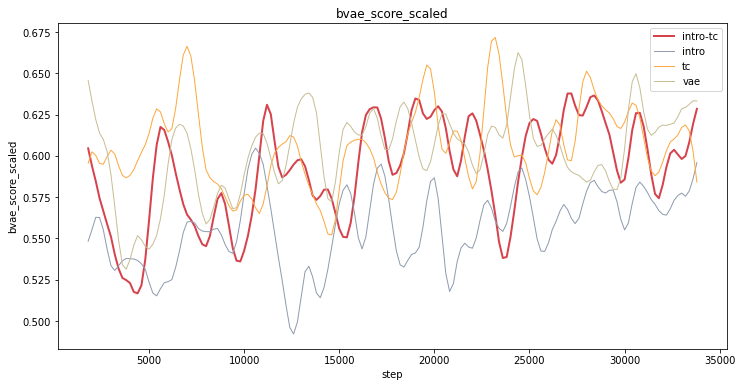

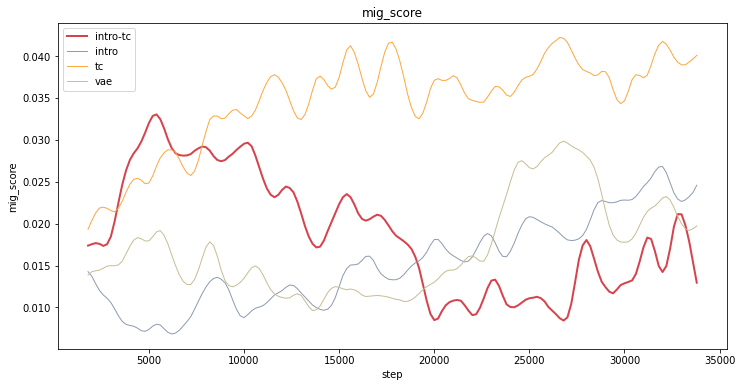

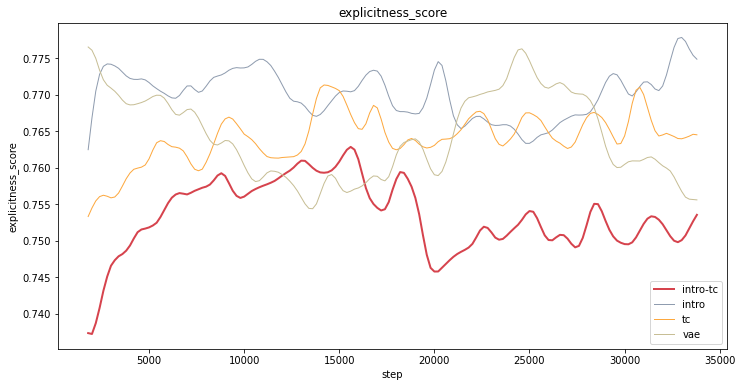

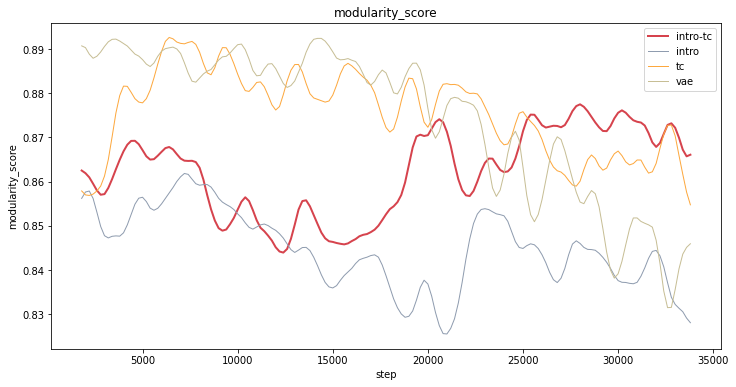

In [29]:
score_list = [("bvae_score_scaled", 10, 2), ("mig_score", 10, 2), ("explicitness_score", 10, 2), ("modularity_score", 10, 2)]

for metric, rolling, std in score_list:
    plot_metric(metric, beta_rec="500.0", rolling=rolling, std=std)

## Loss Plots

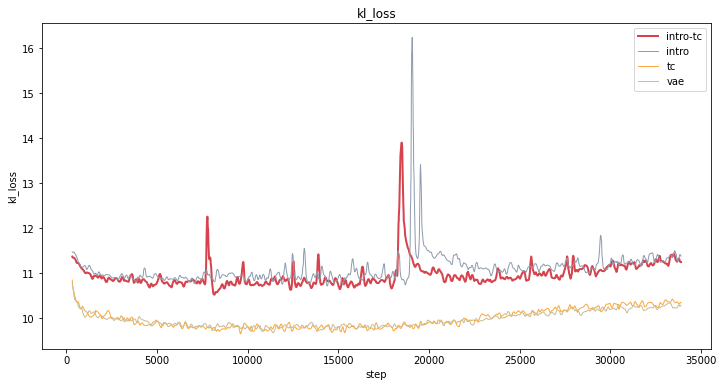

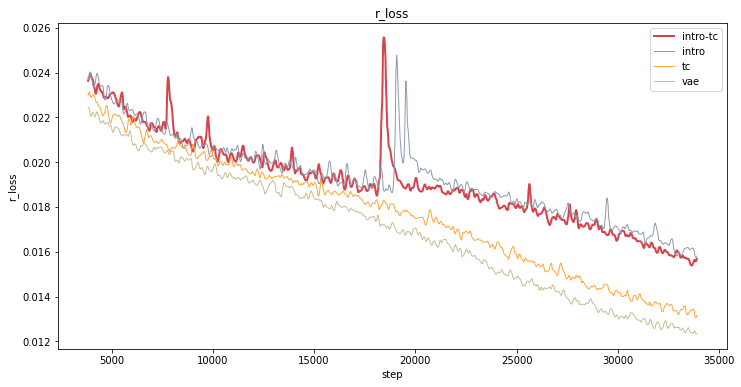

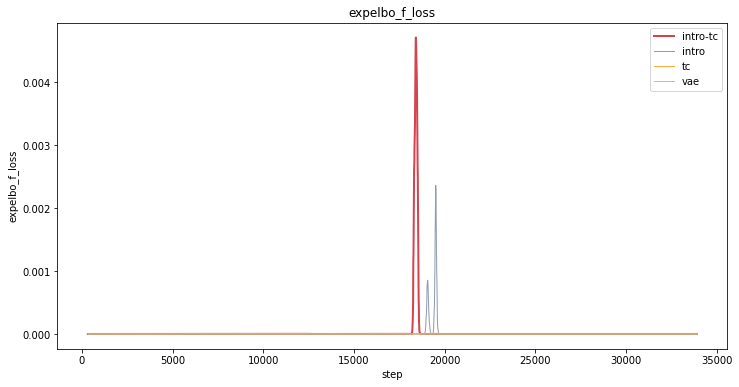

In [30]:
score_list = [("kl_loss", 100, 15, None), ("r_loss", 100, 15, 1000), ("expelbo_f_loss", 100, 15, None)]

for metric, rolling, std, start in score_list:
    plot_metric(metric, beta_rec="500.0", rolling=rolling, std=std, start=start)

# beta_rec Comparison

In [31]:
def plot_compare_metric(metric, beta_recs, beta_kl="1.0", beta_neg="32.0", gamma_r="1e-08", last_n=1):
    tbrs_intro_tc = [(beta_rec, TensorboardReader.get_reader("runs", arch="intro-tc", beta_kl=beta_kl, beta_neg=beta_neg, beta_rec=beta_rec, gamma_r=gamma_r)) for beta_rec in beta_recs]
    tbrs_intro = [(beta_rec, TensorboardReader.get_reader("runs", arch="intro", beta_kl=beta_kl, beta_neg=beta_neg, beta_rec=beta_rec, gamma_r=gamma_r)) for beta_rec in beta_recs]
    tbrs_tc = [(beta_rec, TensorboardReader.get_reader("runs", arch="tc", beta_kl=beta_kl, beta_neg=beta_neg, beta_rec=beta_rec, gamma_r=gamma_r)) for beta_rec in beta_recs]
    tbrs_vae = [(beta_rec, TensorboardReader.get_reader("runs", arch="vae", beta_kl=beta_kl, beta_neg=beta_neg, beta_rec=beta_rec, gamma_r=gamma_r)) for beta_rec in beta_recs]

    metrics_intro_tc = [(beta_rec, getattr(tbr, metric)["value"].tail(last_n).mean()) for beta_rec, tbr in tbrs_intro_tc]
    metrics_intro = [(beta_rec, getattr(tbr, metric)["value"].tail(last_n).mean()) for beta_rec, tbr in tbrs_intro]
    metrics_tc = [(beta_rec, getattr(tbr, metric)["value"].tail(last_n).mean()) for beta_rec, tbr in tbrs_tc]
    metrics_vae = [(beta_rec, getattr(tbr, metric)["value"].tail(last_n).mean()) for beta_rec, tbr in tbrs_vae]

    metric_list = [("intro-tc" ,metrics_intro_tc), ("intro", metrics_intro), ("tc", metrics_tc), ("vae", metrics_vae)]
    dfs = [(name, pd.DataFrame(metric_df, columns=["betas", metric])) for name, metric_df in metric_list]

    fig, ax = plt.subplots(figsize=(12,6))
    for ndf, color in zip(dfs, COLORS):
        name, df = ndf
        lw = 2 if name == "intro-tc" else 1
        ax.plot(df["betas"], df[metric], label=name, color=color, linewidth=lw)
    
    ax.set_title(metric)
    ax.set_xlabel("beta_rec")
    ax.set_ylabel(metric)
    ax.legend()
    fig.show()

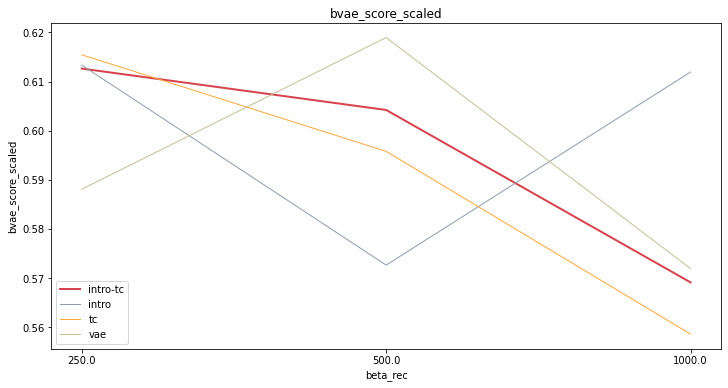

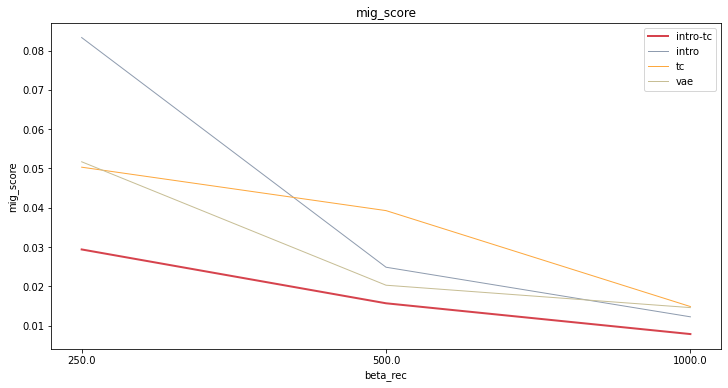

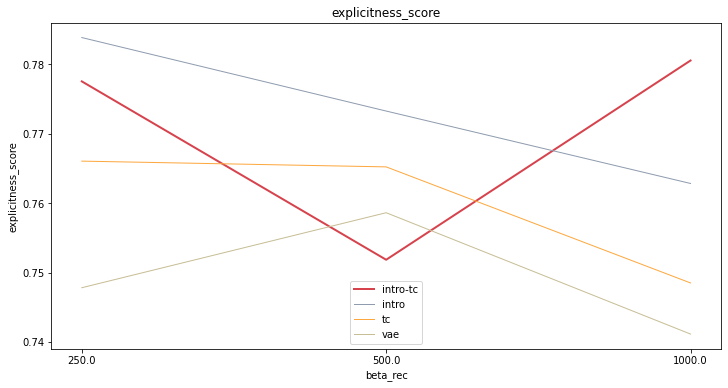

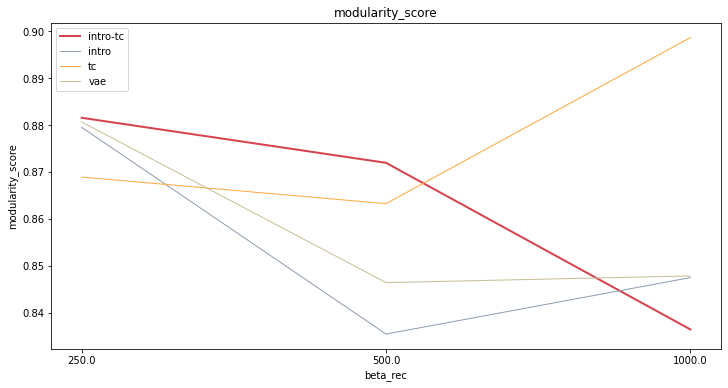

In [32]:
metric_list = ["bvae_score_scaled", "mig_score", "explicitness_score", "modularity_score"]

for metric in metric_list:
    plot_compare_metric(metric, ["250.0", "500.0", "1000.0"], last_n=25)

# Reconstructions

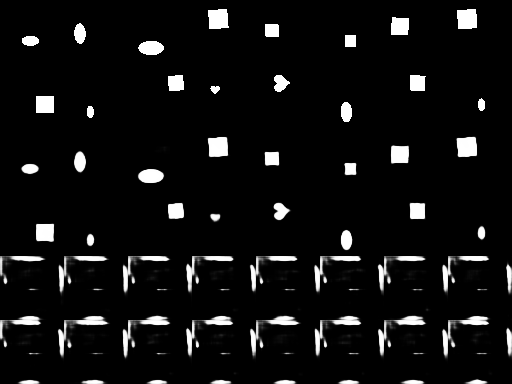

In [8]:
TensorboardReader.get_reader("runs", arch="intro-tc", beta_kl="1.0", beta_neg="32.0", beta_rec="1000.0", gamma_r="1e-08").last_reconstruction

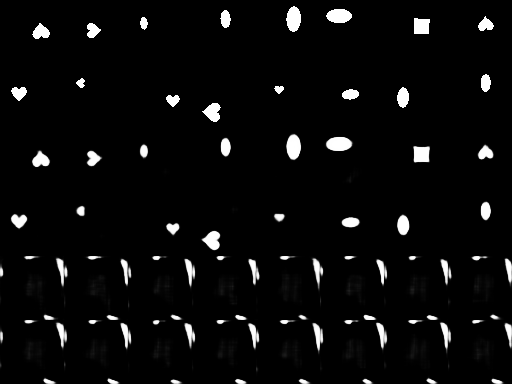

In [9]:
TensorboardReader.get_reader("runs", arch="intro", beta_kl="1.0", beta_neg="32.0", beta_rec="1000.0", gamma_r="1e-08").last_reconstruction

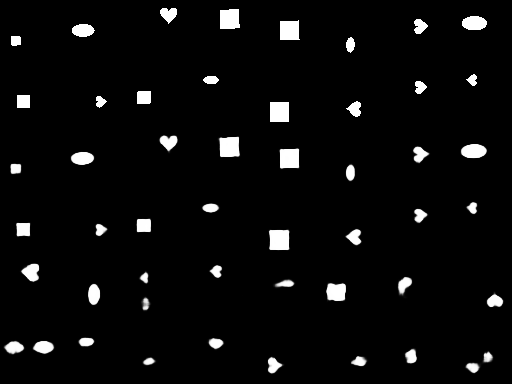

In [10]:
TensorboardReader.get_reader("runs", arch="tc", beta_kl="1.0", beta_neg="32.0", beta_rec="1000.0", gamma_r="1e-08").last_reconstruction

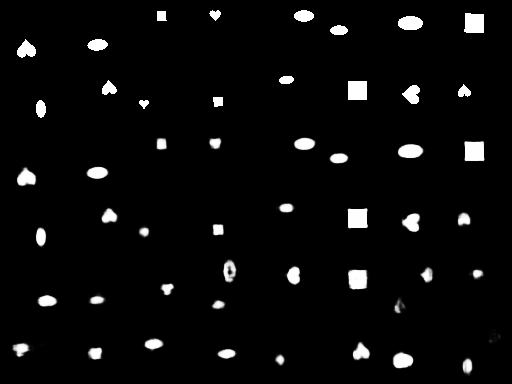

In [11]:
TensorboardReader.get_reader("runs", arch="vae", beta_kl="1.0", beta_neg="32.0", beta_rec="500.0", gamma_r="1e-08").last_reconstruction